# Utilize the `pytket` compilation passes to decrease the number of two-qubit gates

1. Generate a random circuit using qiskit `random_circuit`.
2. Use Qiskit's `IBMProvider` to fetch and set up the IBMQ Jakarta backend with the `QiskitRuntimeService` account.
3. Transpile the circuit using Qiskit's `transpile` function at the highest optimization level, which is level 3.
4. Convert the `qiskit` circuit to a `pytket` circuit using `qiskit_to_tk`.
5. Use TKET's `IBMQBackend` to fetch and set up the IBMQ Jakarta backend.
6. Compile the circuit using TKET's default compilation pass `get_compiled_circuit`.
7. Convert the `pytket` circuit back to a `qiskit` circuit using `tk_to_qiskit`.

Requirments:
- `pytket` 
- `matplotlib` 
- `pytket-qiskit`
- `pytket-quantinuum`

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
#from qiskit_ibm_provider import IBMProvider
#from qiskit_ibm_runtime import QiskitRuntimeService

 # save your IBMProvider accout for future loading
#IBMProvider.save_account(instance="yourinstance", token="yourtoken",overwrite=True)

 # save your QiskitRuntimeService accout for future loading
#QiskitRuntimeService.save_account(
#     channel="ibm_quantum",
#     instance="yourinstance",
#     token="yourtoken"
#)

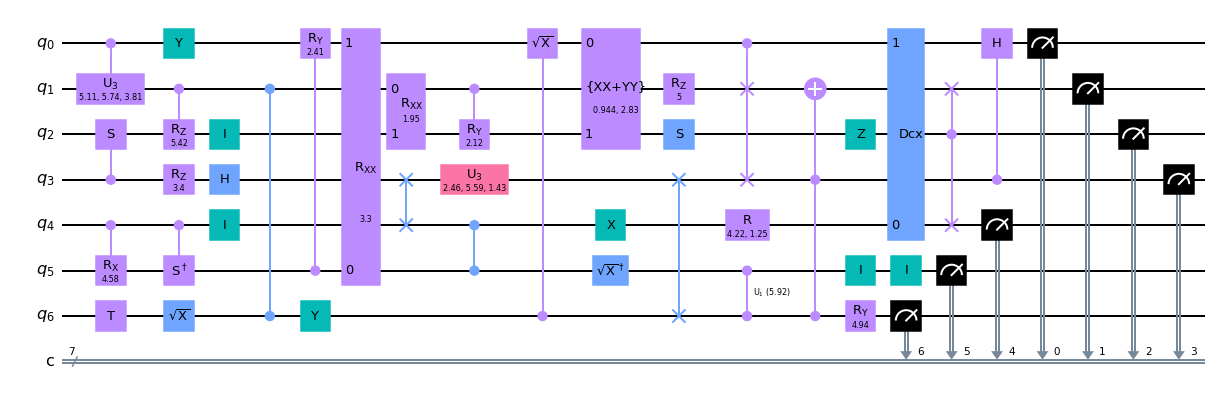

In [21]:
# setup IBMQ Jakarta backend
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
backend = provider.get_backend("ibmq_jakarta")

# import function to create random quantum circuit
from qiskit.circuit.random import random_circuit

# create a random circuit
qc = random_circuit(num_qubits=7, depth=9, max_operands=3, measure=True, seed=0)
qc.draw(output='mpl')  #The 'pylatexenc' library is required to use 'MatplotlibDrawer'


In [22]:
# import the transpile function that performs the transpilation
from qiskit import transpile
transpiled_qc = transpile(qc, backend=backend, optimization_level=3)

transpiled_qc.count_ops()


OrderedDict([('rz', 105),
             ('cx', 104),
             ('sx', 51),
             ('x', 11),
             ('measure', 7),
             ('barrier', 1)])

In [23]:
#transpiled_qc.draw(output='mpl',idle_wires=False)

In [24]:
# import TKET backend
from pytket.extensions.qiskit import IBMQBackend
tket_backend = IBMQBackend('ibmq_jakarta')

# import Qiskt <=> TKET circuit rewrite
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit

# convert already transpiled Qiskit circuit to TKET circuit
tket_qc = qiskit_to_tk(transpiled_qc)

from pytket.circuit.display import render_circuit_jupyter
render_circuit_jupyter(tket_qc)


In [25]:
# use TKET default compilation (transpilation) pass
compiled_tket_qc = tket_backend.get_compiled_circuit(tket_qc)

# convert TKET circuit to Qiskit circuit
compiled_qc = tk_to_qiskit(compiled_tket_qc)

compiled_qc.count_ops()


OrderedDict([('cx', 93),
             ('rz', 91),
             ('sx', 49),
             ('x', 13),
             ('measure', 7),
             ('barrier', 1)])

Qiskit `transpile` (optimization level 3)

| Gate    | Count |
|---------|-------|
| cx      | 104   |
| rz      | 105   |
| sx      | 51    |
| x       | 11    |


combined with TKET `get.compiled` (optimization level 2, default)

| Gate    | Count |
|---------|-------|
| cx      | 93    |
| rz      | 91   |
| sx      | 49    |
| x       | 13    |


# By incorporating the TKET compiler into your workflow, you can potentially decrease the number of two-qubit gates in your circuit. This reduction can help mitigate errors during circuit execution. 

## OpenQASM

- Open quantum assembly language 
- Can be used to write circuits
- Servers as a platform-independent method of storing circuits
- TKET has bidirectional conversion support for QASM

In [31]:
from pytket.qasm import circuit_from_qasm_str
from pytket.circuit.display import render_circuit_jupyter

openqasm = """
// Header
OPENQASM 2.0;
include "qelib1.inc";

// Registers
qreg q[2];
creg cr[2];

// Gates
h q[0];
CX q[0], q[1];

// Measurement
measure q -> cr;

"""

In [32]:
circ = circuit_from_qasm_str(openqasm)
render_circuit_jupyter(circ)


TKET has also bidirectional conversion support for QASM

In [ ]:
from pytket.qasm import circuit_from_qasm, circuit_to_qasm

c = circuit_from_qasm("my_qasm_file.qasm")

c = circuit_from_qasm("my_qasm_file.qasm")


# Quantum Circuit Workflow with Quantinuum

1. **Syntax Checker**: The Syntax Checker ensures that your quantum circuit will run on Quantinuum hardware before submitting jobs. It checks the quantum circuit syntax against a device’s compiler. The Syntax Checker is free to use and does not require H-System Quantum Credits (HQCs).

2. **Emulator**: The Emulator is a classical emulation of the H-Series quantum computers. It implements realistic physical and noise models of the devices. Running circuits on the emulator requires HQCs.

3. **Hardware**: Quantinuum provides trapped ion quantum computers. Running circuits on these devices requires HQCs.

### Note: This section of the notebook requires you to sign into the Quantinuum Device API.

## 1. Syntax Checker

In [1]:
from pytket.circuit import Circuit
from pytket.extensions.quantinuum import QuantinuumBackend

# Set up Bell Test
circuit = Circuit(2)
circuit.H(0)
circuit.CX(0, 1)
circuit.measure_all()

# Select the syntax checking device H1-2 and log in (need to have access to the Quantinuum device)
machine = 'H1-2SC'
backend_sc = QuantinuumBackend(device_name=machine)
backend_sc.login()

# Check the circuit syntax using the Syntax Checker
print("Is the circuit valid before compilation? ", backend_sc.valid_circuit(circuit))


Enter your Quantinuum email:  kathrin.spendier@quantinuum.com
Enter your Quantinuum password:  ········


Is the circuit valid before compilation?  False


In [2]:
# Print the required predicates for the backend
print("Required predicates for the backend: ", backend_sc.required_predicates)


Required predicates for the backend:  [NoSymbolsPredicate, GateSetPredicate:{ Reset Measure ExplicitPredicate CopyBits WASM Barrier MultiBit ZZPhase RangePredicate ZZMax ExplicitModifier Rz ClassicalExpBox SetBits PhasedX }, MaxNQubitsPredicate(20), MaxNClRegPredicate(50)]


In [ ]:
# Compile the circuit
compiled_circuit = backend_sc.get_compiled_circuit(circuit)

# Check the circuit syntax using the Syntax Checker after compilation
print("Is the circuit valid after compilation? ", backend_sc.valid_circuit(compiled_circuit))

render_circuit_jupyter(compiled_circuit)


### NOTE: You can also use the Syntax checker without querying Quantinuum API. See documentation [here](examples/Quantinuum_compile_without_api.ipynb).

In [5]:
# Alternatively,one can investigate circuits compiled for Quantinuum hardware without logging in
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.quantinuum import QuantinuumBackend

machine = "H1-2SC"
backend_sc = QuantinuumBackend(device_name=machine, machine_debug=True)

Users can view the hard-coded native gate set for the Quantinuum backend using the following command.

In [6]:
import pytket.extensions.quantinuum.backends.quantinuum as qtm
print(qtm._GATE_SET)

{<OpType.PhasedX: 66>, <OpType.ClassicalExpBox: 98>, <OpType.Rz: 36>, <OpType.ZZMax: 68>, <OpType.Barrier: 8>, <OpType.WASM: 14>, <OpType.SetBits: 15>, <OpType.CopyBits: 16>, <OpType.RangePredicate: 17>, <OpType.ExplicitPredicate: 18>, <OpType.ExplicitModifier: 19>, <OpType.MultiBit: 20>, <OpType.Measure: 61>, <OpType.Reset: 63>}


It's possible that the hardcoded verion is not up to date with the latest native gate set as described in the [System Model H1 Product Data Sheet](https://www.quantinuum.com/hardware/h1). In this case, the Rzz gate, which is the ZZPhase gate in pytket, is missing. This can be added by running the following command.

In [7]:
from pytket.circuit import OpType
qtm._GATE_SET.add(OpType.ZZPhase)
print(qtm._GATE_SET)

{<OpType.PhasedX: 66>, <OpType.ClassicalExpBox: 98>, <OpType.Rz: 36>, <OpType.ZZMax: 68>, <OpType.ZZPhase: 71>, <OpType.Barrier: 8>, <OpType.WASM: 14>, <OpType.SetBits: 15>, <OpType.CopyBits: 16>, <OpType.RangePredicate: 17>, <OpType.ExplicitPredicate: 18>, <OpType.ExplicitModifier: 19>, <OpType.MultiBit: 20>, <OpType.Measure: 61>, <OpType.Reset: 63>}


In [8]:
print("Required predicates for the backend: ", backend_sc.required_predicates)

Required predicates for the backend:  [NoSymbolsPredicate, GateSetPredicate:{ Reset Measure ExplicitPredicate CopyBits WASM Barrier MultiBit ZZPhase RangePredicate ZZMax ExplicitModifier Rz ClassicalExpBox SetBits PhasedX }]


In [9]:
# Compile the circuit
compiled_circuit = backend_sc.get_compiled_circuit(circuit)

# Check the circuit syntax using the Syntax Checker after compilation
print("Is the circuit valid after compilation? ", backend_sc.valid_circuit(compiled_circuit))

render_circuit_jupyter(compiled_circuit)

Is the circuit valid after compilation?  True


## 2. Emulator:

Recall, the default optimization level is 2. Detailed information regarding passes used for each optimization level can be found [here](https://cqcl.github.io/pytket-quantinuum/api/index.html#default-compilation).

In [11]:
# Select the H1-2 emulation device
machine = 'H1-2E'
backend_emu = QuantinuumBackend(device_name=machine)
backend_emu.login()

# Compile the circuit using default compilation
compiled_circuit = backend_emu.get_compiled_circuit(circuit)

# Check the circuit HQC cost before running on the emulator
n_shots = 100
backend_emu.cost(compiled_circuit, n_shots=n_shots, syntax_checker='H1-1SC')


Enter your Quantinuum email: kathrin.spendier@quantinuum.com
Enter your Quantinuum password: ········


5.66

In [12]:
# Run the circuit on the emulator with n_shots = 100
handle = backend_emu.process_circuit(compiled_circuit, n_shots=n_shots)


The status of a submitted job can be viewed at any time, indicating if a job is in the queue or completed. Additional information is also provided, such as queue position, start times, completion time, and circuit cost in H-Series Quantum Credits (HQCs).

In [13]:
# Check the job status
status = backend_emu.circuit_status(handle)
print(status)


CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "job", "submit-date": "2023-07-15T17:46:11.636656", "result-date": null, "queue-position": null, "cost": "5.66", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


In [15]:
# Once a job's status returns completed, return results
result = backend_emu.get_result(handle)

# It is recommended to save job results as soon as jobs are completed due to the Quantinuum data retention policy
import json
with open('pytket_emulator_example.json', 'w') as file:
    json.dump(result.to_dict(), file)

# The result output is just like that of a quantum device. The simulation by default runs with noise.
print(result.get_distribution())
print(result.get_counts())


{(0, 0): 0.56, (1, 1): 0.44}
Counter({(0, 0): 56, (1, 1): 44})



## 3. Hardware:


In [ ]:

# Select the H1-2 quantum hardware
machine = 'H1-2'
backend_hw = QuantinuumBackend(device_name=machine)
backend_hw.login()

# Resubmit the same compiled circuit to run on the actual quantum hardware
hardware_handle = backend_hw.process_circuit(compiled_circuit, n_shots=n_shots)

# Check the job status
hardware_status = backend_hw.circuit_status(hardware_handle)

# Once a job's status returns completed, return results
hardware_result = backend_hw.get_result(hardware_handle)

# It is recommended to save job results as soon as jobs are completed due to the Quantinuum data retention policy
with open('pytket_hardware_example.json', 'w') as file:
    json.dump(hardware_result.to_dict(), file)

# The result output is the result of the quantum computation on the actual quantum hardware
print(hardware_result.get_distribution())
print(hardware_result.get_counts())


# Circuit Compilation with TKET and Quantinuum H-Series

<div class="alert alert-info" style="padding: 10px">
    <strong>Attention:</strong> Circuits submitted to Quantinuum H-Series quantum computers and emulators are automatically run through TKET compilation passes. This auto-optimization process makes the circuits more efficient for H-Series systems.
</div>



For example:
Use `optimisation_level=0` when running `get_compiled_circuit`, then submit the circuit using `process_circuits` knowing that the corresponding optimization level actually run will be 2.


The specifics of the compilation passes applied can be found in the `pytket-quantinuum` [documentation](https://cqcl.github.io/pytket-quantinuum/api/#default-compilation). The optimization level applied is set with the `tket-opt-level` parameter and the default compilation setting for circuits submitted to H-Series systems is optimization level 2.


If the user desires to have no optimizations applied, use `optimisation_level=0` in `get_compiled_circuit` and `tket-opt-level=None` in `process_circuits`. This should be specified in both functions.


In [ ]:
from pytket.circuit import Circuit, fresh_symbol
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.quantinuum import QuantinuumBackend

# Set up Bell Test
circuit = Circuit(2,)
circuit.H(0).circuit.CX(0, 1).circuit.measure_all()

# Select the emulation device
machine = 'H1-1E'
backend = QuantinuumBackend(device_name=machine)
backend.login()

# Compile the circuit with optimisation_level=0
compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=0)

# Submit the circuit using process_circuits with tket-opt-level=None
handle = backend.process_circuit(compiled_circuit, n_shots=n_shots, tket_opt_level=None)
result = backend.get_result(handle)
print(result.get_counts())


Use the `get_compiled_circuit` function with the desired optimization level to observe the transformed circuit before submitting and then specify `tket-opt-level=None` in the `process_circuits` function when submitting, in order for the optimizations to be applied as desired.


In [ ]:
# Compile the circuit with optimisation_level=1
compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=1)

# Submit the circuit using process_circuits with tket-opt-level=None
handle = backend.process_circuit(compiled_circuit, n_shots=n_shots, tket_opt_level=None)

# Check the job status
status = backend.circuit_status(handle)
print(status)

# Once a job's status returns completed, return results
result = backend.get_result(handle)

print(result.get_distribution())
print(result.get_counts())


Or define your own pass sequence, for example, the <code>FullPeepholeOptimise</code> sequence is a combination of <code>CliffordSimp</code>, <code>RemoveRedundancies</code>, <code>CommuteThroughMultis</code>, <code>KAKDecomposition</code>, and <code>EulerAngleReduction</code>.

In [35]:
from pytket.passes import SequencePass, FullPeepholeOptimise

custom_sequence = SequencePass([FullPeepholeOptimise])
custom_sequence.apply(circuit)

# Submit the circuit using process_circuits with tket-opt-level=None
handle = backend.process_circuit(compiled_circuit, n_shots=n_shots, tket_opt_level=None)

# Check the job status
status = backend.circuit_status(handle)
print(status)

# Once a job's status returns completed, return results
result = backend.get_result(handle)

print(result.get_distribution())
print(result.get_counts())


<div class="alert alert-info" style="padding: 10px">
    <strong> Note:</strong>
The `get_compiled_circuit` function performs the same compilation passes run after submission to Quantinuum systems. This function can be used before submission to observe what circuit optimizations will be performed and decide if a different optimization level is desired.
</div>

# Using Quantinuum Emulators via `pytket`

The emulators available on Quantinuum's platform serve as an essential tool for predicting the behavior of quantum circuits on the actual quantum hardware. They simulate both the physical operations and the noise model of the targeted quantum device.

The Quantinuum emulators may be run with or without the physical device's noise model. The default is the emulator runs with the physical noise model turned on (see example above). The physical noise model can be turned off by setting `noisy_simulation=False`.

In [ ]:
no_error_model_handle = backend.process_circuit(compiled_circuit, 
                                                n_shots=n_shots,
                                                noisy_simulation=False)

# Retrieve results
no_error_model_result = backend.get_result(no_error_model_handle)

print(no_error_model_result.get_distribution())
print(no_error_model_result.get_counts())



You can also experimenting with the noise and error parameters of the emulators. These are advanced options and not recommended to start with when doing initial experiments. 

See the *Quantinuum System Model H1 Emulator Product Data Sheet* on the user portal or [Quantinuum H-Series page](https://www.quantinuum.com/hardware/h1) for information on these parameters:

* *Physical Noise*
* *Dephasing Noise*
* *Arbitrary Angle Noise Scaling*
* *Scaling* (all the error rates can be scaled linearly using the `scale` parameter.)

**Note**: All the noise parameters are used together any time a simulation is run. If only some of the parameters are specified, the rest of the parameters are used at their default settings. The parameters to override are specified with the `options` parameter.

By default, emulations are run using a state-vector emulator, which simulates any quantum operation. However, if the quantum operations are all Clifford gates, it can be faster for complex circuits to use the `stabilizer` emulator. The stabilizer emulator is requested in the setup of the `QuantinuumBackend` with the `simulator` input option. This only applies to Quantinuum emulators. 

In [17]:

machine = 'H1-1E'
stabilizer_backend = QuantinuumBackend(device_name=machine, simulator='stabilizer')

# Run the circuit on the stabilizer emulator
stabilizer_handle = stabilizer_backend.process_circuit(compiled_circuit, n_shots=n_shots)

# Retrieve results
stabilizer_result = stabilizer_backend.get_result(stabilizer_handle)

print(stabilizer_result.get_distribution())
print(stabilizer_result.get_counts())


Note: A noiseless stabilizer simulation can also be specified via options in the `process_circuit` function if desired.

# Partial Results Retrieval with Quantinuum


The `QuantinuumBackend` supports giving the user partial results from unfinished jobs. This feature has a number of potential use cases:

1. **Diagnosing potential faults**: Partial results can be used to diagnose potential faults with submitted jobs. For instance, if the partial results look worse than expected, this could indicate a bug in the submitted circuit(s). If this is the case, the user may want to cancel the job to avoid using machine time and resubmit once the issue is resolved. 

2. **Job duration management**: If partial results indicate that a job is taking longer to run than anticipated, then the user can cancel the job and consider redesigning their experiment.

3. **Validation of large jobs**: Partial results enable users to quickly validate basic execution for very large jobs which may take days to complete.


This can be done as follows:

In [6]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.quantinuum import QuantinuumBackend

# Set up Bell Test
circ = Circuit(2)
circ.H(0).CX(0, 1).measure_all()

# Select the H1-1 emulation device
machine = 'H1-1E'
backend = QuantinuumBackend(device_name=machine)
backend.login()

# Assuming 'circ' is defined elsewhere
compiled_circ = backend.get_compiled_circuit(circ) 
handle = backend.process_circuit(compiled_circ, n_shots=10000)

# Retrieve partial shots:counts from the handle of an unfinished job
partial_result, job_status = backend.get_partial_result(handle)
print(partial_result)


Enter your Quantinuum email: kathrin.spendier@quantinuum.com
Enter your Quantinuum password: ········
None


In [9]:
# Retrieve partial shots:counts from the handle of an unfinished job
partial_result, job_status = backend.get_partial_result(handle)
print(partial_result)


BackendResult(q_bits={},c_bits={c[1]: 0, c[0]: 1},counts=None,shots=[[192]
 [  0]
 [192]
 ...
 [  0]
 [  0]
 [  0]],state=None,unitary=None,density_matrix=None)


In [10]:
print(partial_result.get_counts())


Counter({(1, 1): 4964, (0, 0): 4958, (1, 0): 41, (0, 1): 37})


<div align="center"> &copy; 2023 by Quantinuum. All Rights Reserved. </div>